In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import gc
import os
import time
import pickle

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [1]:
from tensorflow.python.keras.models import load_model

In [6]:
def split_train_test(data, features):
    indexer = data[['s2_cell_id','measure_date']].copy()
    train = data[data.measure_date < '2018-01-01'].copy()
    test = data[data.measure_date >= '2018-01-01'].copy()
    
    y_train = train.wf_wildfire.copy().values
    y_test = test.wf_wildfire.copy().values    
    
    train = train[features]
    test = test[features]    
    
    test_ids = data[data.measure_date >= '2018-01-01'][['s2_cell_id', 'measure_date']]
    
    return train, test, y_train, y_test, test_ids

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Prints and plots the confusion matrix.

    Args:
        y_true: list of true target labels
        y_pred: list of predicted target labels
        classes: tuple of class labels in 0, 1 order

    Kwargs:
        normalize: bool, normalize confusion matrix or not
        cmap: color map
    """

    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix, without normalization')
    print(cm)

    print(classification_report(y_true, y_pred, target_names=classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    
def bin_prob(probs, y_test):
    y_binned = np.digitize(probs, np.arange(0,1.1,0.1))
    bin_df = pd.DataFrame(list(zip(y_test, probs, y_binned)), columns =['Actual', 'Prob', 'Bin'])
    bin_df = bin_df.groupby('Bin').agg({'Actual': ['mean', 'sum', 'count'], 'Prob': 'mean'})
    return bin_df

In [7]:
scaler = MinMaxScaler()

In [8]:
tl_features = [
    'tl_object_id',
    'tl_kv_sort_sum'
]

sat_features = [
 'sat_faparval_min',
 'sat_faparval_max',
 'sat_faparval_mean',
 'sat_faparval_std',
 'sat_faparval_size',
 'sat_faparval_count',
 'sat_faparval',
 'sat_faparmask_min',
 'sat_faparmask_max',
 'sat_faparmask_mean',
 'sat_faparmask_std',
 'sat_faparmask_size'
]

wea_features = [
 'wea_air_temp_max',
 'wea_air_temp_mean',
 'relative_humidity_max',
 'relative_humidity_min',
 'relative_humidity_mean',
 'wea_wind_speed_max',
 'wea_wind_speed_min',
 'wea_wind_speed_mean',
 'wind_gust_max',
 'wea_air_temp_mean_ma7',
 'relative_humidity_mean_ma7',
 'wea_air_temp_mean_l1',
 'relative_humidity_mean_l1',
 'wea_air_temp_mean_ma30',
 'relative_humidity_mean_ma30'
]

fuel_features = [
 'fuel_percent',
 'fuel_percent_ma7',
 'fuel_percent_ma30',
 'fuel_percent_l1',
]

new_tl_features = [
    'tl_s2_cells_lvl16_cnt',
    'tl_s2_cells_lvl16_cnt_coverage'
]

new_control_features = [
 'fz_grp_high',
 'fz_grp_low',
 'fz_grp_med'
]

new_sat_feature = [
  'sat_faparval_median',
  'sat_faparval_undefined'
]

precip_cut50 = [
    'wea_precip_accum_max_cut50',
    'wea_precip_accum_max_ma7_cut50',
    'wea_precip_accum_max_ma30_cut50',
    'wea_precip_accum_max_l1_cut50'
]

precip_cut70 = [
    'wea_precip_accum_max_cut70',
    'wea_precip_accum_max_ma7_cut70',
    'wea_precip_accum_max_ma30_cut70',
    'wea_precip_accum_max_l1_cut70'
]

precip_cut90 = [
    'wea_precip_accum_max_cut90',
    'wea_precip_accum_max_ma7_cut90',
    'wea_precip_accum_max_ma30_cut90',
    'wea_precip_accum_max_l1_cut90'
]

In [9]:
test_df = pd.read_csv('./consolidated_4_2018_new.csv')
test_df.shape

(3884695, 59)

In [10]:
y_test = test_df.wf_wildfire.copy().values    
test_ids = test_df[['s2_cell_id', 'measure_date']]

In [11]:
def build_test(test_df, scaler, features):
    cuts = list(range(0, test_df.shape[0], test_df.shape[0]//10+1))
    cuts[-1] = test_df.shape[0]+1
    test_sc = np.empty([0,len(features)])
    for i in range(len(cuts[:-1])):
        print("Cut: {}".format(cuts[i]))
        temp = test_df[cuts[i]:cuts[i+1]][features]  
        temp = scaler.transform(temp)
        test_sc = np.append(test_sc, temp, axis=0)
    return test_sc

In [12]:
def score_test(data, model_path):
    model = load_model(model_path)
    
    probs = model.predict(data)
    preds = probs[:,0]>0.5
    
    print(bin_prob(probs[:,0], y_test))
    plot_confusion_matrix(y_test, preds, ['nwf', 'wf'], normalize=True)
    
    return probs

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Confusion matrix, without normalization
[[1964584 1918869]
 [    392     850]]
              precision    recall  f1-score   support

         nwf       1.00      0.51      0.67   3883453
          wf       0.00      0.68      0.00      1242

   micro avg       0.51      0.51      0.51   3884695
   macro avg       0.50      0.60      0.34   3884695
weighted avg       1.00      0.51      0.67   3884695



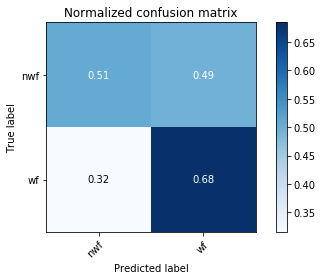

In [14]:
scaler = pickle.load(open('./Models/scaler_10pct_noprecip_cwEQ_ext_new', 'rb'))
feature_cols = wea_features + tl_features + sat_features + fuel_features
test_sc = build_test(test_df, scaler, feature_cols)

       Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000017    4.0  234451  0.044896
2    0.000099   22.0  223337  0.152011
3    0.000186   57.0  306923  0.253459
4    0.000206  102.0  495645  0.353937
5    0.000294  207.0  704620  0.452022
6    0.000352  287.0  816467  0.550168
7    0.000521  389.0  747121  0.646975
8    0.000498  167.0  335441  0.736564
9    0.000347    7.0   20177  0.817247
10   0.000000    0.0     269  0.985043
11   0.000000    0.0     244  1.000000
Confusion matrix, without normalization
[[1964584 1918869]
 [    392     850]]
              precision    recall  f1-score   support

         nwf       1.00      0.51      0.67   3883453
          wf       0.00      0.68      0.00      1242

   micro avg       0.51      0.51      0.51   3884695
   macro avg       0.50      0.60      0.34   3884695
weighted avg       1.00      0.51      0.67   3884695



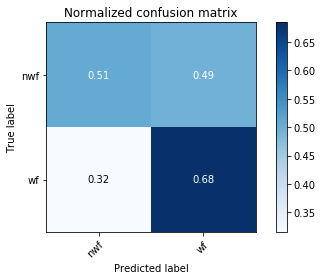

In [16]:
gc.collect()
mlp_adam_noprecip_cwEQ_ext_new_probs = score_test(test_sc, './Models/mlp_adam_noprecip_cwEQ_ext_new.h5')

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760
       Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000029    7.0  239244  0.049040
2    0.000087   22.0  252374  0.152040
3    0.000184   62.0  336089  0.252506
4    0.000221  100.0  452224  0.352151
5    0.000315  179.0  569065  0.451497
6    0.000369  242.0  655685  0.550687
7    0.000429  289.0  673125  0.648227
8    0.000493  272.0  551651  0.746907
9    0.000448   69.0  154039  0.828901
10   0.000000    0.0    1009  0.924870
11   0.000000    0.0     190  1.000000
Confusion matrix, without normalization
[[1848626 2034827]
 [    370     872]]
              precision    recall  f1-score   support

         nwf       1.00      0.48      0.64   3883453
          wf       0.00      0.70      0.00      1242

   micro avg       0.48      0.48      0.48   3884695
   macro avg       0.50      0.59      0.32   38

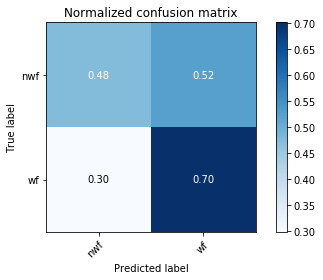

In [25]:
gc.collect()
scaler = pickle.load(open('./Models/scaler_10pct_noprecip_cwEQ_ext_fz', 'rb'))
feature_cols = wea_features + tl_features + sat_features + fuel_features + new_control_features
test_sc = build_test(test_df, scaler, feature_cols)
mlp_adam_noprecip_cwEQ_ext_fz_probs = score_test(test_sc, './Models/mlp_adam_noprecip_cwEQ_ext_fz.h5')

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760
       Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000016    5.0  306129  0.050880
2    0.000088   26.0  294768  0.151386
3    0.000124   49.0  395921  0.252861
4    0.000157   82.0  523453  0.351703
5    0.000258  160.0  620057  0.450410
6    0.000382  234.0  612927  0.549893
7    0.000569  326.0  573405  0.649428
8    0.000649  303.0  466834  0.743709
9    0.000650   57.0   87697  0.828279
10   0.000000    0.0    3426  0.950736
11   0.000000    0.0      78  1.000000
Confusion matrix, without normalization
[[2140007 1743446]
 [    322     920]]
              precision    recall  f1-score   support

         nwf       1.00      0.55      0.71   3883453
          wf       0.00      0.74      0.00      1242

   micro avg       0.55      0.55      0.55   3884695
   macro avg       0.50      0.65      0.36   38

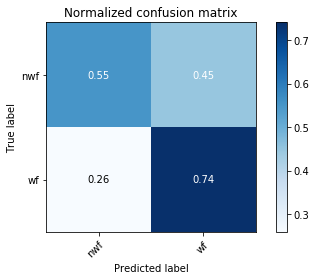

In [26]:
gc.collect()
scaler = pickle.load(open('./Models/scaler_10pct_precip50_cwEQ_ext_new', 'rb'))
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut50
test_sc = build_test(test_df, scaler, feature_cols)
mlp_adam_precip50_cwEQ_ext_new_probs = score_test(test_sc, './Models/mlp_adam_precip50_cwEQ_ext_new.h5')

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760
       Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000016    4.0  253272  0.050352
2    0.000067   18.0  269598  0.152664
3    0.000101   45.0  445851  0.254941
4    0.000154   90.0  583178  0.349180
5    0.000259  138.0  531984  0.450266
6    0.000451  275.0  609165  0.551063
7    0.000567  375.0  661790  0.651511
8    0.000560  259.0  462368  0.739459
9    0.000575   38.0   66122  0.826602
10   0.000000    0.0    1166  0.949211
11   0.000000    0.0     201  1.000000
Confusion matrix, without normalization
[[2083588 1799865]
 [    295     947]]
              precision    recall  f1-score   support

         nwf       1.00      0.54      0.70   3883453
          wf       0.00      0.76      0.00      1242

   micro avg       0.54      0.54      0.54   3884695
   macro avg       0.50      0.65      0.35   38

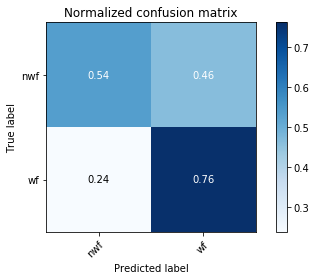

In [27]:
gc.collect()
scaler = pickle.load(open('./Models/scaler_10pct_precip70_cwEQ_ext_new', 'rb'))
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut70
test_sc = build_test(test_df, scaler, feature_cols)
mlp_adam_precip70_cwEQ_ext_new_probs = score_test(test_sc, './Models/mlp_adam_precip70_cwEQ_ext_new.h5')

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760
       Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000030    7.0  236148  0.046302
2    0.000088   22.0  250119  0.151508
3    0.000161   54.0  336326  0.253481
4    0.000212  108.0  508515  0.353013
5    0.000289  190.0  658305  0.451601
6    0.000354  263.0  743908  0.550094
7    0.000502  363.0  723068  0.648654
8    0.000535  209.0  390824  0.739437
9    0.000704   26.0   36921  0.822470
10   0.000000    0.0     324  0.969054
11   0.000000    0.0     237  1.000000
Confusion matrix, without normalization
[[1989033 1894420]
 [    381     861]]
              precision    recall  f1-score   support

         nwf       1.00      0.51      0.68   3883453
          wf       0.00      0.69      0.00      1242

   micro avg       0.51      0.51      0.51   3884695
   macro avg       0.50      0.60      0.34   38

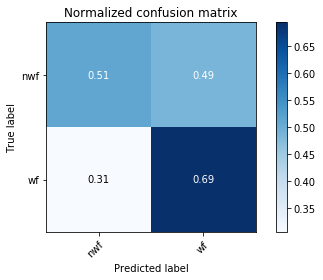

In [28]:
gc.collect()
scaler = pickle.load(open('./Models/scaler_10pct_precip90_cwEQ_ext_new', 'rb'))
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut90
test_sc = build_test(test_df, scaler, feature_cols)
mlp_adam_precip90_cwEQ_ext_new_probs = score_test(test_sc, './Models/mlp_adam_precip90_cwEQ_ext_new.h5')

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
       Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000033   13.0  390009  0.046428
2    0.000119   44.0  370692  0.151858
3    0.000156   74.0  473172  0.251813
4    0.000215  119.0  552209  0.351064
5    0.000290  170.0  586480  0.449797
6    0.000360  191.0  530975  0.548639
7    0.000618  323.0  522750  0.651298
8    0.000676  283.0  418687  0.739956
9    0.000664   25.0   37661  0.823159
10   0.000000    0.0    1949  0.958077
11   0.000000    0.0     111  1.000000
Confusion matrix, without normalization
[[2372142 1511311]
 [    420     822]]
              precision    reca

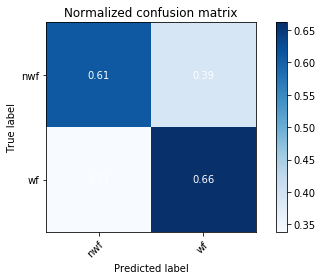

In [13]:
gc.collect()
scaler = pickle.load(open('./Models/scaler_10pct_precip50_cwEQ_ext_other', 'rb'))
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut50 + new_tl_features + new_control_features + ['sat_faparval_median']
test_sc = build_test(test_df, scaler, feature_cols)
mlp_adam_precip50_cwEQ_ext_other_probs = score_test(test_sc, './Models/mlp_adam_precip50_cwEQ_ext_other.h5')

Cut: 0
Cut: 388470
Cut: 776940
Cut: 1165410
Cut: 1553880
Cut: 1942350
Cut: 2330820
Cut: 2719290
Cut: 3107760
       Actual                     Prob
         mean    sum   count      mean
Bin                                   
1    0.000022    6.0  269009  0.049695
2    0.000072   17.0  234530  0.150599
3    0.000140   46.0  328167  0.254117
4    0.000152   77.0  505557  0.352609
5    0.000262  163.0  623270  0.450898
6    0.000320  192.0  600488  0.549539
7    0.000528  296.0  560168  0.649277
8    0.000602  325.0  540078  0.747387
9    0.000522  111.0  212629  0.835928
10   0.000841    9.0   10707  0.923033
11   0.000000    0.0      92  1.000000
Confusion matrix, without normalization
[[1960224 1923229]
 [    309     933]]
              precision    recall  f1-score   support

         nwf       1.00      0.50      0.67   3883453
          wf       0.00      0.75      0.00      1242

   micro avg       0.50      0.50      0.50   3884695
   macro avg       0.50      0.63      0.34   38

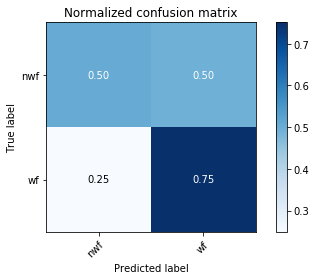

In [34]:
gc.collect()
scaler = pickle.load(open('./Models/scaler_10pct_precip50_cwEQ_ext_fz_sat', 'rb'))
feature_cols = wea_features + tl_features + sat_features + fuel_features + precip_cut50 + new_control_features + ['sat_faparval_undefined']
test_sc = build_test(test_df, scaler, feature_cols)
mlp_adam_precip50_cwEQ_ext_fz_sat_probs = score_test(test_sc, './Models/mlp_adam_precip50_cwEQ_ext_fz_sat.h5')

In [35]:
with open('./Models/mlp_adam_noprecip_cwEQ_ext_new_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+','+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_noprecip_cwEQ_ext_new_probs[i,0])+'\n')

In [36]:
with open('./Models/mlp_adam_precip50_cwEQ_ext_new_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+','+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_precip50_cwEQ_ext_new_probs[i,0])+'\n')

In [37]:
with open('./Models/mlp_adam_precip70_cwEQ_ext_new_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+','+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_precip70_cwEQ_ext_new_probs[i,0])+'\n')

In [14]:
with open('./Models/mlp_adam_precip50_cwEQ_ext_other_probs.csv', 'w') as filename:
    filename.write('S2_Cells_ID'+','+'DATE_DT_DT'+','+'Probability'+'\n')
    for i in range(test_ids.shape[0]):
        filename.write(test_ids.loc[i,'s2_cell_id']+','+test_ids.loc[i,'measure_date']+','+str(mlp_adam_precip50_cwEQ_ext_other_probs[i,0])+'\n')